<img style="border-radius: 0.5rem;" src="banner.jpg" />
<a style="margin-top: 1rem;" class="btn btn-lg btn-block btn-success" href="https://dsg.ucfsigai.org/fa18/signin/">
    Sign in (https://dsg.ucfsigai.org/fa18/signin/)
</a>

# Intro to Neural Nets, featuring PyTorch
---
by: John Muchovej \([@jmuchovej](github.com/jmuchovej/)\), Chas Kane \([@ChasKane](github.com/ChasKane/)\), on 26 Sep 2018

## Dependencies

As with every lecture, we're loading up dependencies and configurations as well.

In [1]:
# lines with '%' in front are called "Jupyter Magic Commands"
#   they effectively set certain properties of Jupyter Notebooks 
#   for you, and allow the Notebook to be more usable
%matplotlib inline
# this is for high-density displays, so that matplotlib doesn't
#   render oversized plots on newer displays
%config InlineBackend.figure_format = 'retina'

# these two snippets allow for modules loaded from
#     `import X` or `from X import Y`
#   to be reloaded whenever the source file changes, without 
#   having to re-run the code cell
%load_ext autoreload
%autoreload 2

---
## The actual lecture

We're going to load-up a model which has already been prepared for you. We'll train it, look at it's output, and then we'll peel back the layers to understand what's happening.

In [2]:
from mnist_model import MnistModel
model = MnistModel()
model.prepare()

/home/john/.conda/envs/sigai-fa18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


**What just happened here?**
1. We loaded in a magical class, called `MnistModel`.
1. Ran some `MnistModel.prepare()` function (and saw something download).

We'll get to what `MnistModel` consists of in a bit. In the mean time, `prepare` just grabs the MNIST dataset (handwritten digits from 0-9) and sets it up so that the `MnistModel` can access it.

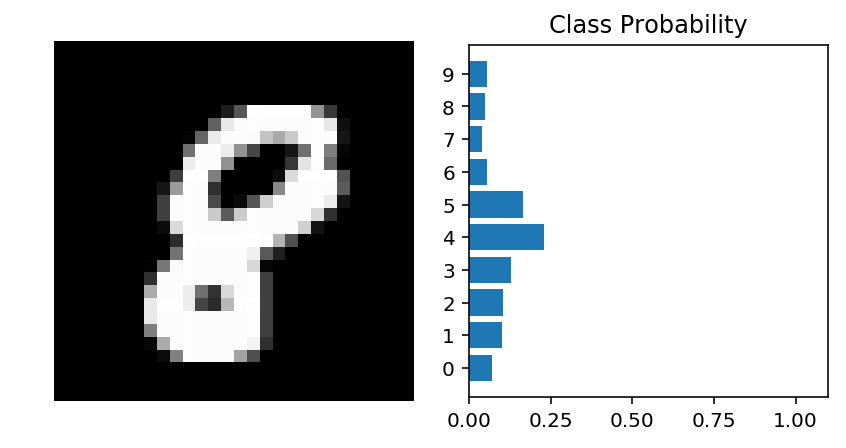

In [3]:
model.test()

`MnistModel.test()` grabs a random image from our dataset, then hands it off to the Neural Network to classify as one of 10 digits \[0-9\]. As you can see, it has no idea what it's doing.

**What's classification?**

Oh, right; so, Neural Networks are class of algorithms which are really well suited to two tasks.
1. Classification – imagine you have a bunch of images and want to sort them into boxes, each box is a "class" that an image belongs to. Putting an image into a box is "classification."
2. Regression – Snapchat filters do something similar, they take images of your face, do some fancy stuff, and eventually return coordinates for the filter to map onto your face. This last bit is regression – it's taking an input and outputting real-valued data, like coordinate pairs.

---
### Training the model

Let's train the model, this shouldn't take more than 5-10 minutes, on a processor made in the last 3 years. It'll use your graphics card if you have one, but no worries if you don't. :) (We'll dissect this in a bit.)

In [4]:
model.fit()

Epoch:  1, Average Loss: 0.695, Accuracy: 0.921
Epoch:  2, Average Loss: 0.230, Accuracy: 0.946
Epoch:  3, Average Loss: 0.155, Accuracy: 0.960
Epoch:  4, Average Loss: 0.117, Accuracy: 0.964
Epoch:  5, Average Loss: 0.092, Accuracy: 0.969
Epoch:  6, Average Loss: 0.075, Accuracy: 0.973
Epoch:  7, Average Loss: 0.064, Accuracy: 0.968
Epoch:  8, Average Loss: 0.055, Accuracy: 0.975
Epoch:  9, Average Loss: 0.045, Accuracy: 0.973
Epoch: 10, Average Loss: 0.040, Accuracy: 0.973



So, you just saw this run for 10 epochs, and there were a few numbers that just plopped out. We'll consider what those numbers mean a bit later on. Run the next code cell to see how the network does on a random image from the dataset.

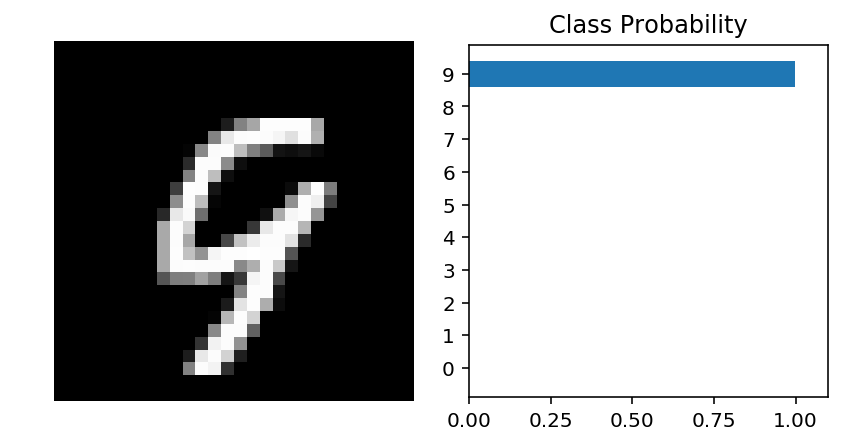

In [5]:
model.test()

WHOA. That looks a LOT better. Now we're getting pretty close to 100% certainty on what class the image falls in to. :D

---
### Let's break this down

As it shows in the `model.fit()` snippet; there were 10 epochs. One **epoch** corresponds to *one* loop through our entire dataset. So what's our dataset, you might ask?

Well, let's take a look.

In [6]:
len(model.loader_train.dataset)

60000

That's 60,000 images :astonished:, all handwritten digits from \[0-9\]. These digits form what's called our training set – that's what that progress bar above was, too. Neural Networks, like most machine learning algorithms, need to be trained on data, only then can they make predictions.

There's another dataset, too; it's the testing dataset. These are where the two images that have been shown with `model.test()` came from – they're also how the graph ("Average Accuracy, per Epoch") was generated*.

\* If you run the code two cells below, you'll see the plot being referred to.

In [7]:
len(model.loader_test.dataset)

10000

The testing dataset only has 10,000 images. It's quite the norm to have a smaller testing set than training set, simply because Neural Networks chew through quite a bit of data, quite a few times, before they get a handle on their goals. This makes having a large training set more important than having a large testing set.

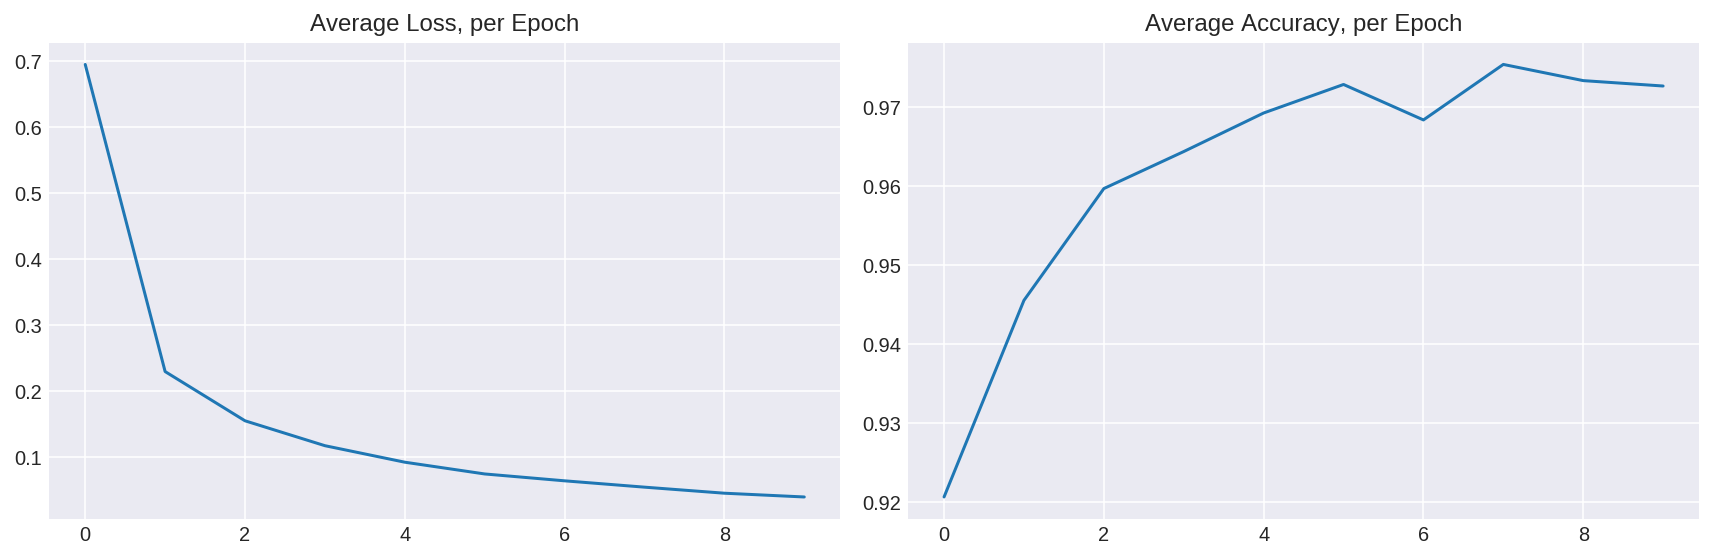

In [8]:
model.plot()

**So what do these graphs mean?**

Well, the first ("Average Loss, per Epoch") is a graph of loss over the course of training. **Loss** is the feedback that a Neural Network receives; this feedback is then used to "learn from it's mistakes" – this is akin to a professor giving a multiple choice exam, marking the questions you got wrong while telling you what the correct answer is, then using this new information to move closer to getting a perfect score (while having to take different tests every time). Sounds complex, right? (No worries, we'll break it down in a bit.) **NOTE:** A loss of `0.5234` doesn't mean we got `0.4766` solutions correct, this value can go well above `1`.

As for the second... ("Average Accuracy, per Epoch"), this takes the network at the end of each epoch and tests it on the test dataset (`model.loader_test.dataset` from earlier). Initially, we start in the low 90s, and eventually move up to right around `97%` accuracy! :smiley: For a first Neural Network, that's a pretty great attempt.

But now, time to move away from just running cells and actually understand what's going on inside this network.

---
### Breaking into the network

Beware, **_math_** follows. (Don't fret, it's pretty straightfoward, and it'll be well explained. If you still find it difficult, just ping #halp on Slack, and someone will come to your rescue.)

Before diving into math, though, let's take a look at information flow.

When you run the cell below, try to have the text below it in view – this will walk you through interacting with this `IFrame`. (It may require use of a phone, or another window, sorry! :confused:)

In [9]:
from IPython.display import IFrame
import math
NN_SVG_W = 732
NN_SVG_H = math.ceil(NN_SVG_W * 0.7076502732) + 20
IFrame("assets/fwd.html", width=NN_SVG_W, height=NN_SVG_H)

Alright, this is a Neural Network (you might also see this called a "Fully Connected Network" – "FCN" or "Feedforward Neural Network" – "FFNN"). 

1. Looking at the first column (from the left), click on one of the `x`s. What's just been selected is called a `Layer` in Neural Networks. Within each `Layer`, you'll also find many `Unit`s.
1. If you now click in the white-space between the first two layers, you'll see a mass of grey-ish lines link up with all the `Unit`s in the next `Layer`. These grey-ish lines are called `Weights`, and they are what the network trains to be able to do things, like classify the digits we saw earlier.
1. If you repeat the process:
   - click on one of the `Unit`s in a `Layer` followed by...
   - click on the white-space between `Layer`s, you'll see that this same idea propagates through the network.

So, to clear up some confusion, let's introduce some notation:
1. The left-most `Layer`, let's call it the "Input Layer" and represent is with a vector (named: $\vec{x}$).
1. The first `Layer` with the "h"s, let's call that the "**First** Hidden Layer" and represent that as a vector (named: $\vec{h}_1$).
1. The second `Layer` with the "h"s, let's call it the "**Second** Hidden Layer" and represent it as a vector (named: $\vec{h}_2$).
1. The last `Layer`, the one with "o"s, let's call it the "Output Layer" and represent it with a vector (named: $\vec{o}$).


- **Whoa! What's a vector?!** Oh, right; just think of it like an array in Python. :smiley:
- **Why do we need vectors?** You'll see. :smiley: They also make life simpler when we want to perform operations on an entire `Layer`s and `Weights`.

Now, let's think about the `Weights` connecting each layer to the next. To avoid deviating from notation you'll see in research, we'll only refer to weights as $W$, and rely on context to know **_which_** set of weights we're talking about.

**Talking about the `Input Layer` ($\vec{x}$)**

Our images in the MNIST dataset are 28x28 pixels. We have a slight problem if we want to represent these images in a way the Neural Network can consume, though. Recall from the last block of text that we have an "Input Layer" ($\vec{x}$), this is how we feed in our images.

This is how we might represent an image of a 6 in memory, but this takes the form of a matrix (a 2D array).

<center>
    <img src="https://mmlind.github.io/images/mnist-image.svg" />
    <small>Image credit: <A href="https://mmlind.github.io/images/mnist-image.svg">https://mmlind.github.io/images/mnist-image.svg</a></small>
</center>

So, instead of trying to pass this in, we'll flatten this image. You might observe that if we flatten this image, we'll loose a lot of spacial information because each row will just be appended to a single vector (a 1D array).

This is something we'll expand on in the CNN lecture next week.

But, now that we have a flattened image in our "Input Layer" ($\vec{x}$), we can set up it's weight matrix to pass it through to $\vec{h_1}$.

**Before we hop into the math surrounding $\vec{x} \rightarrow \vec{h_1}$, let's figure out what `Weights` do**

So, `Weights` were the lines connecting one layer to the next – in the animation above. In FCNs (Fully Connect Networks), each weight modifies a copy of the input by some amount and passes it on to the node in the next layer it's connected to.

Let's display the figure again, then talk about it more mathematically.

In [10]:
IFrame("assets/fwd.html", width=NN_SVG_W, height=NN_SVG_H)

We can think of the input to $h_{1,1}$ ($h_1$'s top node) as... $x_1 \cdot w_{1,1} + x_2 \cdot w_{2,1} + x_3 \cdot w_{3,1}$. 

$x_n$ just refers to the node in $\vec{x}$ (the "Input Layer"), while $w_{nm}$ refers to the weight from $x_n$ going to $h_{1,m}$ (which in our case, is $h_1$).

More concretely:

$h_{1,1} = x_1 \cdot w_{1,1} + x_2 \cdot w_{2,1} + x_3 \cdot w_{3,1}$

$h_{1,2} = x_1 \cdot w_{1,2} + x_2 \cdot w_{2,2} + x_3 \cdot w_{3,2}$

$h_{1,3} = x_1 \cdot w_{1,3} + x_2 \cdot w_{2,3} + x_3 \cdot w_{3,3}$

$h_{1,4} = x_1 \cdot w_{1,4} + x_2 \cdot w_{2,4} + x_3 \cdot w_{3,4}$

Do you see a pattern here? (Hint: think of each operation in terms of the columns!)

If we do some `%%latex` magic...

In [11]:
%%latex
\begin{align*}
    \begin{bmatrix} h_{1,1} \\ h_{1,2} \\ h_{1,3} \\ h_{1,4} \\ \end{bmatrix} = 
    x_{1} \cdot \begin{bmatrix} w_{1,1} \\ w_{1,2} \\ w_{1,3} \\ w_{1,4} \\ \end{bmatrix} +
    x_{2} \cdot \begin{bmatrix} w_{2,1} \\ w_{2,2} \\ w_{2,3} \\ w_{2,4} \\ \end{bmatrix} +
    x_{3} \cdot \begin{bmatrix} w_{1,1} \\ w_{1,2} \\ w_{1,3} \\ w_{1,4} \\ \end{bmatrix}
\end{align*}

<IPython.core.display.Latex object>

We get, this! 

An observation that may not be immediately obvious is that we can represent sets of vectors as a matrix. There's a computational efficiency reason behind using matrix-vector dot products (which I shan't cover), but doing this preserves our ability to apply activations and backprop! :D

In [12]:
%%latex
\begin{align*}
    \begin{bmatrix} h_{1,1} \\ h_{1,2} \\ h_{1,3} \\ h_{1,4} \\ \end{bmatrix} = 
    \begin{bmatrix} 
        w_{1,1} \quad w_{2,1} \quad w_{3,1} \\
        w_{1,2} \quad w_{2,2} \quad w_{3,2} \\
        w_{1,3} \quad w_{2,3} \quad w_{3,3} \\
        w_{1,4} \quad w_{2,4} \quad w_{3,4} \\
    \end{bmatrix} \cdot
    \begin{bmatrix} x_{1} \\ x_{2} \\ x_{3} \\ \end{bmatrix}
\end{align*}

<IPython.core.display.Latex object>

Here's what the dot-product looks like, in terms of math. What you end up getting out is a vector, which corresponds to $h_1$ (in this case). We can then apply some activation function (that's the next thing we'll talk about).

In [13]:
!head -n 52 mnist_model.py | tail -n 11

    def forward(self, x):
        
        x = torch.sigmoid(self.x_(x))
        
        x = torch.sigmoid(self.h1(x))
        
        x = torch.sigmoid(self.h2(x))
        
        x = F.log_softmax(self.o_(x), dim=1)
        
        return x


Above is a really crude way to look at the source code. BUT... we can see a few things:
1. There are references to `self.x_`, `self.h1`, `self.h2`, `self.o_` – these are the layers (will output in next code cell)
2. There's some `torch.`**`sigmoid`** function
3. There's some `F.`**`log_softmax`** function

In [14]:
print(model)

MnistModel(
  (x_): Linear(in_features=784, out_features=512, bias=True)
  (h1): Linear(in_features=512, out_features=256, bias=True)
  (h2): Linear(in_features=256, out_features=128, bias=True)
  (o_): Linear(in_features=128, out_features=10, bias=True)
  (criterion): NLLLoss()
)


We won't talk much about `softmax` (or `log_softmax`) today. However, this and `sigmoid` are called "activation functions." Without going to deep into the history of Neural Nets / Multi-Layer Perceptrons (see the Appendix), we learned that the neurons in the pile of mush reading this will accumulate some input and, eventually, fire with some magnitude (e.g. the neuron may fire strongly, or could fire weakly).

To mimic this, we use activation functions – so **all** `Unit`s fire, but they fire with different magnitudes. 

For instance, with a `sigmoid` function...

In [15]:
import torch

In [16]:
torch.sigmoid(torch.Tensor([340427593085348]))

tensor([1.])

In [17]:
torch.sigmoid(torch.Tensor([1]))

tensor([0.7311])

In [18]:
torch.sigmoid(torch.Tensor([0]))

tensor([0.5000])

In [19]:
torch.sigmoid(torch.Tensor([-1]))

tensor([0.2689])

In [20]:
torch.sigmoid(torch.Tensor([-340427593085348]))

tensor([0.])

As you can see, putting in different values gets us between `[0, 1]`, so our `Unit`s will fire with greater magnitudes when they have higher positive values, and very weakly with highly negative values.

To give you a better idea, here's a better picture of a sigmoid function:

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png">
<small>Image credit: <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png">Wikipedia</a></small>
</center>

For more info on activation functions, take a gander at the Appendix. The important things to remeber is that activation functions normally modify the next layer's  and they're crucial in giving us a means by which the Neural Network can learn.

**To summarize:**

Neural Networks are composed of `Layers` and `Weights`, which connect the layers together (in a one-way fashion). We can represent `Layers` as vectors and `Weights` as matrices; this allows us to do some cool mathematical tricks to speed up computation and more concisely represent them.

Once we've calculate the dot-product on `Weights` $\cdot$ `Layer`, we get another vector which we can then apply an `Activation Function` to. This `Activation Function` serves two purposes – it allows each `Unit` in the next layer to "fire" with some compressed value, rather than just passing along it's raw input, **AND** it lets us perform the learning step (more on this in a bit).

---
## How data flows *back* through the network

We just covered the first of a "two-step process" in Neural Networks. First, out input flows through the network, and we get some output. Then we're told how poorly it did, and that difference (between our guess and the right answer) is then used to update all the weights in the network.

This second step (getting the difference and updating the weights) is called backpropagation (or backprop, for short).

Before we take a look at the network ready to go, below, let's recap on some annotation to for familiarity.
1. The left-most `Layer`, it's called the "Input Layer" and is represented by the vector $\vec{x}$.
1. The first `Layer` with the "h"s is called the "**First** Hidden Layer" and is represented with the vector $\vec{h}_1$.
1. The second `Layer` with the "h"s, is called the "**Second** Hidden Layer" and we represent it by the vector $\vec{h}_2$.
1. The last `Layer`, the one with "o"s, is called the "Output Layer" and it's represented by vector $\vec{o}$.

In [21]:
IFrame("assets/bkp.html", width=NN_SVG_W, height=NN_SVG_H)

This is the ending state of the FCN diagram you saw earlier. 

1. Looking at the last column, the "Output Layer" ($\vec{o}$), click one of its `Unit`s.
1. Now, click in the space between $\vec{o}$ and $\vec{h_2}$, and you should see the weights go from grey-ish to red.
1. You'll be able to repreat the process on all the preceeding layers, just:
   - click on one of the `Unit`s in a `Layer` followed by...
   - click on the white-space between `Layer`s, you'll see that this same idea propagate through the network.
   
What the reverse flow means, though, is distributing the error from the `Layer` to its preceeding layer, so...
- $\vec{h_2} \leftarrow \vec{o}$
- $\vec{h_1} \leftarrow \vec{h_2}$
- $\vec{x} \leftarrow \vec{h_1}$

In the forward propagation, we took values from the `Unit`s in each layer, multiplied them by some weights, and summed them in the `Unit`s of the next layer, right? (Hint: you should be nodding yes.) :stuck_out_tongue: (If not, keep reading, then give this another read-through!)

Now, we'll do the reverse! So... $\vec{o}$ has some values corresponding to the error of each `Unit` in the "Output Layer." So we'll ignore some calculus that happens then distribute the error across the weights back to the `Unit`s in the preceeding layer (so from "Output Layer" to "Second Hidden Layer" or $\vec{o} \rightarrow \vec{h_2}$). At each `Unit` in $\vec{h_2}$, we'll sum the errors from the `Unit`s in $\vec{o}$, and then pass those errors back, repeating this process until we get to the "Input Layer"!

### What's an error function?

Oh, right. LOL. So, an error function is a way to measure the difference between your guesses and the correct answer – hence the requirement of labeled data. It's what informs the value that gets pushed back from $\vec{o}$ to the preceeding hidden layers.

### What's a softmax?

Most activation functions don't yield results which sum to 1; this is important becase if we want to say, "with X% likelihood, this image is a 4" – we need all the values to sum to 1, as only then will we have "probabilities."

Softmax will take the outcomes and normalize them so that we have a final outcome which sums to 1, making it acceptable to state "with X% likelihood, this image is a 6" whereas before we couldn't.

## Activation functions
https://rasbt.github.io/mlxtend/user_guide/general_concepts/activation-functions_files/activation-functions.png

https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0